In [19]:
# Basic scientific libraries
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# Statsmodels is the primarily library used here
# for Bayesian inference of time series models
import statsmodels.api as sm

# Output from Markov chain Monte Carlo (MCMC)
# simulations is naturally multidimensional and
# tends to be quite large. The xarray and ArviZ
# libraries make it easy to work with.
import xarray as xr
import arviz as az

# Formatting settings for the notebook
np.set_printoptions(suppress=True, linewidth=120)

In [20]:
def draw_mh_step(mod, ix, params, llf, prior_llf, prior, rw, uniform):
    """
    Sample a parameter in RWMH iteration
    
    Parameters
    ----------
    mod : sm.tsa.statespace.mlemodel.MLEModel
        State space model object (for example, in the two
        applications above this would have been an instance
        of sm.tsa.UnobservedComponents)
    ix : int
        Index of the parameter to be sampled within
        the `params` array.
    params : array_like
        Current values of the parameters in the Markov
        chain.
    llf : float
        Log-likelihood of the data at the given `params`
        array.
    prior_llf : float
        Prior log-likelihood of `params[ix]`
    prior : scipy random variable object
        Prior distribution (e.g. the example of this from
        above was `stats.uniform(0.001, 100)`).
    rw : stats.norm object
        Perturbation distribution. Should be Normal with
        mean zero.
    uniform : stats.uniform object
        Standard uniform distribution object (used for
        choosing whether to accept the proposal)
        
    Returns
    -------
    draw : float
        Sampled parameter at index `ix`.
    accept : bool
        Whether or not the proposal was accepted.
    llf : float
        Log-likelihood of the data after accepting or
        rejecting the proposal.
    prior_llf : float
        Prior log-likelihood of sampled `draw`.
    """
    accept = 0

    # Draw the proposal value from the random walk
    # proposal distribution
    proposal = params.copy()
    proposal[ix] += rw.rvs()
    proposal_prior_llf = prior.logpdf(proposal[ix])

    # (if the proposal is not in the support of the
    # prior, then we definitely won't accept it)
    if proposal_prior_llf > -np.inf:

        # Construct the acceptance probability
        proposal_llf = mod.loglike(proposal)
        inner = (proposal_llf - llf +
                 proposal_prior_llf - prior_llf)

        if inner > 0:
            acceptance_probability = 1
        else:
            acceptance_probability = np.exp(inner)

        # If we accept the proposal, save the parameter
        # and likelihood values
        if (acceptance_probability == 1
                or acceptance_probability > uniform.rvs()):
            params[ix] = proposal[ix]
            llf = proposal_llf
            prior_llf = proposal_prior_llf
            accept = 1

        # Note: if we didn't accept, then `params[ix]`
        # is unmodified from what was originally passed
        # in to the function

    return params[ix], accept, llf, prior_llf


In [21]:
def draw_ig_gs_step(equation, ix, mod, states, prior):
    """
    Sample a variance parameter in Gibbs sampling iteration
    
    Assumes a state space model and an inverse-Gamma prior.
    
    Parameters
    ----------
    equation : {'observation', 'state'}
        State space system equation in which the variance
        parameter occurs.
    ix : int or iterable of int
        Index of the variance parameter or parameters to be
        sampled within the given equation. For example, if
        `equation="observation"` and `ix=[0, 1]`, then this
        function samples the variance associated with the
        first column of the data.
    mod : sm.tsa.statespace.mlemodel.MLEModel
        State space model object (for example, in the two
        applications above this would have been an instance
        of sm.tsa.UnobservedComponents)
    states : array_like
        Current values of the latent state vector in the
        Markov chain.
    prior : stats.invgamma object or list of stats.invgamma
        Prior distribution(s) for the variance parameter(s).
        
    Returns
    -------
    draw : float or array_like
        Sampled parameter(s) at index `ix` in equation
        `equation`.
    """
    # Retrieve the prior hyperparameters
    if isinstance(prior, (list, tuple)):
        prior_shape = np.array([p.args[0] for p in prior])
        prior_scale = np.array([p.kwds['scale'] for p in prior])
    else:
        prior_shape = prior.args[0]
        prior_scale = prior.kwds['scale']

    # Compute the appropriate residual
    if equation == 'observation':
        d = mod['obs_intercept', ix]
        Z = mod['design', ix, :]
        resid = mod.endog[:, ix] - d - states @ Z.T
    elif equation == 'state':
        c = mod['state_intercept', ix]
        T = mod['transition', ix, :]
        resid = states[1:, ix] - c - states[:-1] @ T.T

    squeeze = False
    if resid.ndim == 1:
        squeeze = True
        resid = resid[:, np.newaxis]

    # Draw from the conditional posterior
    post_shape = np.sum(~np.isnan(resid), axis=0) / 2 + prior_shape
    post_scale = np.nansum(resid**2, axis=0) / 2 + prior_scale
    draw = np.array([stats.invgamma(post_shape[i], scale=post_scale[i]).rvs()
                     for i in range(resid.shape[1])])

    if squeeze:
        draw = draw[0]

    return draw

In [22]:
esiData = pd.read_csv("../Datasets/ESI_Clean.csv")
esiData

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,208,209,210,211,212,213,214,215,216,217
0,Month-Year,Jan-05,Feb-05,Mar-05,Apr-05,May-05,Jun-05,Jul-05,Aug-05,Sep-05,...,May-22,Jun-22,Jul-22,Aug-22,Sep-22,Oct-22,Nov-22,Dec-22,Jan-23,Feb-23
1,EU.ESI,100.4,99.4,98.4,98.1,97.3,97.4,98.5,99.8,100.3,...,103.6,101.9,97.8,97.1,93.9,92.8,94.1,95.6,97.8,97.8
2,EA.ESI,100.1,98.9,97.9,97.8,96.7,96.9,98.2,99.2,99.9,...,104.2,103.0,98.6,97.8,94.4,93.8,95.1,97.1,99.8,99.7
3,BE.ESI,105.3,104.4,102.6,98.1,94.6,97.0,94.8,96.9,99.9,...,97.8,97.7,98.0,92.9,86.0,83.4,82.4,88.0,87.4,88.9
4,BG.ESI,112.4,106.2,106.3,108.1,108.7,112.4,109.9,101.7,107.3,...,95.0,98.7,100.0,99.4,99.4,100.1,103.4,103.5,101.6,102.1
5,CZ.ESI,108.9,108.6,105.4,105.2,108.0,105.9,110.2,106.9,109.1,...,97.0,95.0,89.5,87.7,89.5,83.9,82.2,83.3,88.5,92.0
6,DK.ESI,106.3,107.6,106.0,97.6,100.9,100.2,96.9,106.7,102.6,...,94.2,88.5,86.2,90.0,82.4,74.5,78.7,77.7,78.3,79.6
7,DE.ESI,94.1,92.9,90.7,91.4,92.1,91.4,92.8,94.2,95.3,...,106.6,104.6,99.4,97.0,92.7,91.6,92.9,95.3,97.8,97.9
8,EE.ESI,105.8,107.7,110.1,110.1,110.7,110.3,113.1,111.2,109.8,...,95.7,92.5,89.5,88.5,84.8,84.4,84.3,81.2,83.5,82.6
9,EL.ESI,103.7,103.2,102.2,102.4,101.9,100.4,100.2,101.5,102.4,...,107.4,104.2,100.5,100.7,105.7,99.0,101.6,103.7,105.9,107.5


In [23]:
esiData.iloc[0][1:len(esiData.iloc[0])].values

array(['Jan-05', 'Feb-05', 'Mar-05', 'Apr-05', 'May-05', 'Jun-05', 'Jul-05', 'Aug-05', 'Sep-05', 'Oct-05', 'Nov-05',
       'Dec-05', 'Jan-06', 'Feb-06', 'Mar-06', 'Apr-06', 'May-06', 'Jun-06', 'Jul-06', 'Aug-06', 'Sep-06', 'Oct-06',
       'Nov-06', 'Dec-06', 'Jan-07', 'Feb-07', 'Mar-07', 'Apr-07', 'May-07', 'Jun-07', 'Jul-07', 'Aug-07', 'Sep-07',
       'Oct-07', 'Nov-07', 'Dec-07', 'Jan-08', 'Feb-08', 'Mar-08', 'Apr-08', 'May-08', 'Jun-08', 'Jul-08', 'Aug-08',
       'Sep-08', 'Oct-08', 'Nov-08', 'Dec-08', 'Jan-09', 'Feb-09', 'Mar-09', 'Apr-09', 'May-09', 'Jun-09', 'Jul-09',
       'Aug-09', 'Sep-09', 'Oct-09', 'Nov-09', 'Dec-09', 'Jan-10', 'Feb-10', 'Mar-10', 'Apr-10', 'May-10', 'Jun-10',
       'Jul-10', 'Aug-10', 'Sep-10', 'Oct-10', 'Nov-10', 'Dec-10', 'Jan-11', 'Feb-11', 'Mar-11', 'Apr-11', 'May-11',
       'Jun-11', 'Jul-11', 'Aug-11', 'Sep-11', 'Oct-11', 'Nov-11', 'Dec-11', 'Jan-12', 'Feb-12', 'Mar-12', 'Apr-12',
       'May-12', 'Jun-12', 'Jul-12', 'Aug-12', 'Sep-12', 'Oct-12

In [24]:
floatTimeSeries = []
c = 0
for value in esiData.iloc[1].values:
    if c != 0:
        floatTimeSeries.append(float(value))
    c += 1
floatTimeSeries

[100.4,
 99.4,
 98.4,
 98.1,
 97.3,
 97.4,
 98.5,
 99.8,
 100.3,
 102.0,
 102.2,
 103.3,
 105.2,
 105.5,
 106.2,
 107.7,
 108.1,
 108.3,
 108.6,
 109.2,
 109.9,
 110.7,
 110.9,
 112.0,
 110.5,
 111.1,
 111.2,
 111.6,
 111.3,
 111.0,
 110.6,
 109.5,
 107.9,
 107.6,
 106.9,
 106.2,
 104.7,
 103.1,
 102.3,
 100.1,
 98.9,
 94.9,
 91.9,
 89.5,
 89.0,
 83.0,
 77.9,
 71.9,
 71.8,
 69.5,
 68.5,
 70.6,
 74.6,
 77.1,
 79.9,
 84.0,
 86.4,
 88.5,
 90.1,
 92.2,
 93.3,
 93.3,
 95.3,
 98.2,
 97.2,
 97.2,
 99.1,
 100.2,
 101.3,
 101.4,
 102.3,
 102.8,
 102.8,
 103.2,
 102.6,
 101.8,
 101.5,
 100.9,
 99.3,
 96.5,
 94.2,
 93.3,
 92.9,
 91.0,
 91.2,
 91.7,
 92.5,
 92.0,
 90.2,
 89.9,
 88.3,
 87.5,
 86.4,
 85.3,
 86.1,
 86.6,
 88.1,
 88.9,
 88.9,
 88.1,
 88.7,
 90.0,
 90.8,
 92.9,
 95.5,
 95.5,
 96.6,
 97.4,
 98.4,
 98.7,
 99.7,
 99.3,
 99.1,
 98.8,
 98.6,
 97.8,
 97.0,
 97.7,
 98.0,
 98.1,
 99.2,
 101.0,
 102.6,
 102.6,
 102.5,
 102.4,
 102.5,
 102.8,
 103.9,
 104.2,
 104.5,
 104.7,
 104.6,
 103.9,
 103.

In [25]:
import pandas as pd
import numpy as np
import pymc as pm
from scipy import optimize

# Load time series data
#data = pd.read_csv('time_series_data.csv', parse_dates=['date'], index_col='date')
obs = floatTimeSeries[:150]

In [26]:

# Define Bayesian model
with pm.Model() as model:
    # Priors for the parameters
    beta = pm.Normal('beta', mu=0, sigma=10)
    sigma = pm.HalfCauchy('sigma', 5)

    # Define time series model
    trend = pm.AR('trend', rho=beta, sigma=sigma, observed=obs)

    # Sample posterior using MCMC
    trace = pm.sample(2000, tune=1000)


c:\Users\jackm\.conda\envs\main\Lib\site-packages\pymc\distributions\timeseries.py:556: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.


In [27]:
trace['observed_data']['trend'][0:-1]

<xarray.DataArray 'trend' (trend_dim_0: 149)>
array([100.4,  99.4,  98.4,  98.1,  97.3,  97.4,  98.5,  99.8, 100.3, 102. , 102.2, 103.3, 105.2, 105.5, 106.2, 107.7,
       108.1, 108.3, 108.6, 109.2, 109.9, 110.7, 110.9, 112. , 110.5, 111.1, 111.2, 111.6, 111.3, 111. , 110.6, 109.5,
       107.9, 107.6, 106.9, 106.2, 104.7, 103.1, 102.3, 100.1,  98.9,  94.9,  91.9,  89.5,  89. ,  83. ,  77.9,  71.9,
        71.8,  69.5,  68.5,  70.6,  74.6,  77.1,  79.9,  84. ,  86.4,  88.5,  90.1,  92.2,  93.3,  93.3,  95.3,  98.2,
        97.2,  97.2,  99.1, 100.2, 101.3, 101.4, 102.3, 102.8, 102.8, 103.2, 102.6, 101.8, 101.5, 100.9,  99.3,  96.5,
        94.2,  93.3,  92.9,  91. ,  91.2,  91.7,  92.5,  92. ,  90.2,  89.9,  88.3,  87.5,  86.4,  85.3,  86.1,  86.6,
        88.1,  88.9,  88.9,  88.1,  88.7,  90. ,  90.8,  92.9,  95.5,  95.5,  96.6,  97.4,  98.4,  98.7,  99.7,  99.3,
        99.1,  98.8,  98.6,  97.8,  97. ,  97.7,  98. ,  98.1,  99.2, 101. , 102.6, 102.6, 102.5, 102.4, 102.5, 102.8,
       103.9, 104.2, 104.5, 104.7, 104.6, 103.9, 103.5, 103.8, 103.6, 103.6, 103.4, 103. , 103.9, 105.2, 105.9, 107.1,
       107.9, 107.9, 108.4, 109.3, 109. ])
Coordinates:
  * trend_dim_0  (trend_dim_0) int32 0 1 2 3 4 5 6 ... 143 144 145 146 147 148

In [28]:
# Extract posterior samples
beta_samples = trace['posterior']["beta"]
sigma_samples = trace['posterior']['sigma']
print(beta_samples.mean().values)


1.000584354610579


In [29]:

# Define forecast function
def forecast(data, beta_samples, sigma_samples, n=10):
    # Define model for forecasting
    with pm.Model() as forecast_model:
        # Prior for the regression coefficient
        beta = pm.Normal('beta', mu=beta_samples.mean().values, sigma=beta_samples.std().values)
        sigma = pm.HalfCauchy('sigma', sigma_samples.mean().values)

        # Define forecast distribution
        trend = pm.AR('trend', rho=beta, sigma=sigma, observed=data)

        # Sample posterior using MCMC
        forecast_trace = pm.sample(2000, tune=1000)

    # Extract forecast samples
    forecast_samples = forecast_trace['observed_data']['trend']
    forecast_mean = forecast_samples.mean().values
    forecast_std = forecast_samples.std().values

    # Calculate credible interval
    ci = np.percentile(forecast_samples, [2.5, 97.5])

    return forecast_mean, forecast_std, ci

# Perform forecast
forecast_mean, forecast_std, ci = forecast(obs, beta_samples, sigma_samples, n=10)

print(f'Forecast mean: {forecast_mean:.2f}')
print(f'Forecast standard deviation: {forecast_std:.2f}')
print(f'95% Credible interval: {ci}')


c:\Users\jackm\.conda\envs\main\Lib\site-packages\pymc\distributions\timeseries.py:556: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.


Forecast mean: 98.16
Forecast standard deviation: 9.37
95% Credible interval: [ 71.8725 111.1275]


In [30]:
forecast_mean

array(98.16066667)

In [31]:
obs.append(96.58)

In [32]:
floatTimeSeries

[100.4,
 99.4,
 98.4,
 98.1,
 97.3,
 97.4,
 98.5,
 99.8,
 100.3,
 102.0,
 102.2,
 103.3,
 105.2,
 105.5,
 106.2,
 107.7,
 108.1,
 108.3,
 108.6,
 109.2,
 109.9,
 110.7,
 110.9,
 112.0,
 110.5,
 111.1,
 111.2,
 111.6,
 111.3,
 111.0,
 110.6,
 109.5,
 107.9,
 107.6,
 106.9,
 106.2,
 104.7,
 103.1,
 102.3,
 100.1,
 98.9,
 94.9,
 91.9,
 89.5,
 89.0,
 83.0,
 77.9,
 71.9,
 71.8,
 69.5,
 68.5,
 70.6,
 74.6,
 77.1,
 79.9,
 84.0,
 86.4,
 88.5,
 90.1,
 92.2,
 93.3,
 93.3,
 95.3,
 98.2,
 97.2,
 97.2,
 99.1,
 100.2,
 101.3,
 101.4,
 102.3,
 102.8,
 102.8,
 103.2,
 102.6,
 101.8,
 101.5,
 100.9,
 99.3,
 96.5,
 94.2,
 93.3,
 92.9,
 91.0,
 91.2,
 91.7,
 92.5,
 92.0,
 90.2,
 89.9,
 88.3,
 87.5,
 86.4,
 85.3,
 86.1,
 86.6,
 88.1,
 88.9,
 88.9,
 88.1,
 88.7,
 90.0,
 90.8,
 92.9,
 95.5,
 95.5,
 96.6,
 97.4,
 98.4,
 98.7,
 99.7,
 99.3,
 99.1,
 98.8,
 98.6,
 97.8,
 97.0,
 97.7,
 98.0,
 98.1,
 99.2,
 101.0,
 102.6,
 102.6,
 102.5,
 102.4,
 102.5,
 102.8,
 103.9,
 104.2,
 104.5,
 104.7,
 104.6,
 103.9,
 103.

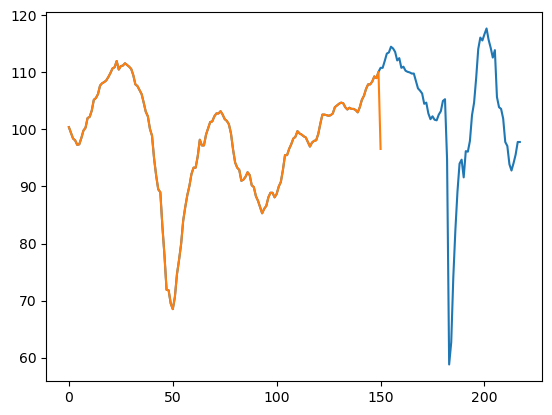

In [33]:
plt.plot(floatTimeSeries)
plt.plot(obs)